In [1]:
!pip install ../input/kerasefficientnetb3/efficientnet-1.0.0-py3-none-any.whl

Processing /kaggle/input/kerasefficientnetb3/efficientnet-1.0.0-py3-none-any.whl


In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline 
import cv2
import math  # for mathematical operations
from keras.preprocessing import image   # for preprocessing the images
from keras.utils import np_utils
from skimage.transform import resize   # for resizing images
from sklearn.model_selection import train_test_split
from keras.applications.vgg19 import VGG19
from sklearn import metrics
import tensorflow as tf
import glob
from tqdm.notebook import tqdm
import os
import efficientnet.keras as efn
from keras.layers import *
from keras import Model
import keras
from keras.models import Sequential
from keras.applications.vgg16 import VGG16
from keras.layers import Dense, InputLayer, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D
from keras.preprocessing import image

Using TensorFlow backend.


In [3]:
from PIL import Image
from PIL import ImageFilter

In [4]:
TF_WEIGHTS_PATH = '../input/vgg19/vgg19_weights_tf_dim_ordering_tf_kernels.h5'
TF_WEIGHTS_PATH_NO_TOP = '../input/vgg19/vgg19_weights_tf_dim_ordering_tf_kernels_notop.h5'

In [5]:
def VGG_19(include_top=True, weights='imagenet',input_tensor=None):
    input_shape = (None, None, 3)
    if input_tensor is None:
        img_input = Input(shape=input_shape)
    else:
        if not K.is_keras_tensor(input_tensor):
            img_input = Input(tensor=input_tensor)
        else:
            img_input = input_tensor
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv1')(img_input)
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv2')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool')(x)

    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv1')(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv2')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool')(x)

    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv1')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv2')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv3')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv4')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool')(x)

    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv1')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv2')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv3')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv4')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool')(x)

    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv1')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv2')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv3')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv4')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block5_pool')(x)

    if include_top:
        x = Flatten(name='flatten')(x)
        x = Dense(4096, activation='relu', name='fc1')(x)
        x = Dense(4096, activation='relu', name='fc2')(x)
        x = Dense(1000, activation='softmax', name='predictions')(x)

    model = Model(img_input, x)
    if include_top:
        weights_path = TF_WEIGHTS_PATH
    else:
        weights_path = TF_WEIGHTS_PATH_NO_TOP
    model.load_weights(weights_path)
    return model

In [6]:
DATA_FOLDER = '../input/deepfake-detection-challenge'
TRAIN_SAMPLE_FOLDER = 'train_sample_videos'
TEST_FOLDER = 'test_videos'

print(f"Train samples: {len(os.listdir(os.path.join(DATA_FOLDER, TRAIN_SAMPLE_FOLDER)))}")
print(f"Test samples: {len(os.listdir(os.path.join(DATA_FOLDER, TEST_FOLDER)))}")

Train samples: 401
Test samples: 400


In [7]:
train_list = list(os.listdir(os.path.join(DATA_FOLDER, TRAIN_SAMPLE_FOLDER)))
ext_dict = []
for file in train_list:
    file_ext = file.split('.')[1]
    if (file_ext not in ext_dict):
        ext_dict.append(file_ext)
print(f"Extensions: {ext_dict}")      

Extensions: ['mp4', 'json']


In [8]:
def get_img(images):
    global boxes,scores,num_detections
    im_heights,im_widths=[],[]
    imgs=[]
    for image in images:
        (im_height,im_width)=image.shape[:-1]
        imgs.append(image)
        im_heights.append(im_height)
        im_widths.append(im_widths)
    imgs=np.array(imgs)
    (boxes, scores_) = sess.run(
        [boxes_tensor, scores_tensor],
        feed_dict={image_tensor: imgs})
    finals=[]
    for x in range(boxes.shape[0]):
        scores=scores_[x]
        max_=np.where(scores==scores.max())[0][0]
        box=boxes[x][max_]
        ymin, xmin, ymax, xmax = box
        (left, right, top, bottom) = (xmin * im_width, xmax * im_width,
                                      ymin * im_height, ymax * im_height)
        left, right, top, bottom = int(left), int(right), int(top), int(bottom)
        image=imgs[x]
        finals.append(cv2.cvtColor(cv2.resize(image[max([0,top-40]):bottom+80,max([0,left-40]):right+80],(240,240)),cv2.COLOR_BGR2RGB))
    return finals
def detect_video(video):
    frame_count=10
    capture = cv2.VideoCapture(video)
    v_len = int(capture.get(cv2.CAP_PROP_FRAME_COUNT))
    frame_idxs = np.linspace(0,v_len,frame_count, endpoint=False, dtype=np.int)
    imgs=[]
    i=0
    for frame_idx in range(int(v_len)):
        ret = capture.grab()
        if not ret: 
            print("Error grabbing frame %d from movie %s" % (frame_idx, video))
        if frame_idx >= frame_idxs[i]:
            if frame_idx-frame_idxs[i]>20:
                return None
            ret, frame = capture.retrieve()
            if not ret or frame is None:
                print("Error retrieving frame %d from movie %s" % (frame_idx, video))
            else:
                frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                imgs.append(frame)
            i += 1
            if i >= len(frame_idxs):
                break
    imgs=get_img(imgs)
    if len(imgs)<10:
        return None
    return np.hstack(imgs)
def get_birghtness(img):
    return img/img.max()
def process_img(img,flip=False):
    imgs=[]
    for x in range(10):
        if flip:
            imgs.append(get_birghtness(cv2.flip(img[:,x*240:(x+1)*240,:],1)))
        else:
            imgs.append(get_birghtness(img[:,x*240:(x+1)*240,:]))
    return np.array(imgs)

In [9]:
detection_graph = tf.Graph()
with detection_graph.as_default():
    od_graph_def = tf.compat.v1.GraphDef()
    with tf.io.gfile.GFile('../input/mobilenet-face/frozen_inference_graph_face.pb', 'rb')as fid:
        serialized_graph = fid.read()
        od_graph_def.ParseFromString(serialized_graph)
        tf.import_graph_def(od_graph_def, name='')
cm = detection_graph.as_default()
cm.__enter__()
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
sess=tf.compat.v1.Session(graph=detection_graph, config=config)
image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')
boxes_tensor = detection_graph.get_tensor_by_name('detection_boxes:0')
scores_tensor = detection_graph.get_tensor_by_name('detection_scores:0')
num_detections = detection_graph.get_tensor_by_name('num_detections:0')

In [10]:
os.mkdir('../train_videos_cut/')

In [11]:
for x in tqdm(glob.glob('../input/deepfake-detection-challenge/train_sample_videos/*.mp4')):
    try:
        filename=x.replace('../input/deepfake-detection-challenge/train_sample_videos/','').replace('.mp4','.jpg')
        a=detect_video(x)
        if a is None:
            continue
        cv2.imwrite('../train_videos_cut/'+filename,a)
    except Exception as err:
        print(err)

In [12]:
os.mkdir('../test_videos_cut/')

In [13]:

for x in tqdm(glob.glob('../input/deepfake-detection-challenge/test_videos/*.mp4')):
    try:
        filename=x.replace('../input/deepfake-detection-challenge/test_videos/','').replace('.mp4','.jpg')
        a=detect_video(x)
        if a is None:
            continue
        cv2.imwrite('../test_videos_cut/'+filename,a)
    except Exception as err:
        print(err)

In [14]:
train_imgs=glob.glob("../train_videos_cut/*.jpg")
train_imgs

['../train_videos_cut/esxrvsgpvb.jpg',
 '../train_videos_cut/djvutyvaio.jpg',
 '../train_videos_cut/aneclqfpbt.jpg',
 '../train_videos_cut/asvcrfdpnq.jpg',
 '../train_videos_cut/dzyuwjkjui.jpg',
 '../train_videos_cut/emaalmsonj.jpg',
 '../train_videos_cut/cbltdtxglo.jpg',
 '../train_videos_cut/bejhvclboh.jpg',
 '../train_videos_cut/aybumesmpk.jpg',
 '../train_videos_cut/bqqpbzjgup.jpg',
 '../train_videos_cut/awukslzjra.jpg',
 '../train_videos_cut/bqdjzqhcft.jpg',
 '../train_videos_cut/bbhpvrmbse.jpg',
 '../train_videos_cut/ckbdwedgmc.jpg',
 '../train_videos_cut/cwqlvzefpg.jpg',
 '../train_videos_cut/dzwkmcwkwl.jpg',
 '../train_videos_cut/avssvvsdhz.jpg',
 '../train_videos_cut/dhoqofwoxa.jpg',
 '../train_videos_cut/cmxcfkrjiv.jpg',
 '../train_videos_cut/cferslmfwh.jpg',
 '../train_videos_cut/esyrimvzsa.jpg',
 '../train_videos_cut/aladcziidp.jpg',
 '../train_videos_cut/cgvrgibpfo.jpg',
 '../train_videos_cut/dptbnjnkdg.jpg',
 '../train_videos_cut/cqhngvpgyi.jpg',
 '../train_videos_cut/cpj

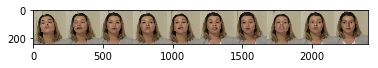

In [15]:
plt.imshow(plt.imread('../train_videos_cut/eqvuznuwsa.jpg', ))
plt.show() 

In [16]:
test_imgs=glob.glob("../test_videos_cut/*.jpg")
test_imgs

['../test_videos_cut/nwvsbmyndn.jpg',
 '../test_videos_cut/dvwpvqdflx.jpg',
 '../test_videos_cut/vizerpsvbz.jpg',
 '../test_videos_cut/nkhzxomani.jpg',
 '../test_videos_cut/eywdmustbb.jpg',
 '../test_videos_cut/sjinmmbipg.jpg',
 '../test_videos_cut/lebzjtusnr.jpg',
 '../test_videos_cut/ljauauuyka.jpg',
 '../test_videos_cut/cekarydqba.jpg',
 '../test_videos_cut/elackxuccp.jpg',
 '../test_videos_cut/mnowxangqx.jpg',
 '../test_videos_cut/siebfpwuhu.jpg',
 '../test_videos_cut/ncmpqwmnzb.jpg',
 '../test_videos_cut/wixbuuzygv.jpg',
 '../test_videos_cut/dnmowthjcj.jpg',
 '../test_videos_cut/ajiyrjfyzp.jpg',
 '../test_videos_cut/wjhpisoeaj.jpg',
 '../test_videos_cut/xrtvqhdibb.jpg',
 '../test_videos_cut/ztyuiqrhdk.jpg',
 '../test_videos_cut/hevcclcklc.jpg',
 '../test_videos_cut/nxgzmgzkfv.jpg',
 '../test_videos_cut/fmhiujydwo.jpg',
 '../test_videos_cut/ptbfnkajyi.jpg',
 '../test_videos_cut/cxsvvnxpyz.jpg',
 '../test_videos_cut/qlvsqdroqo.jpg',
 '../test_videos_cut/tjywwgftmv.jpg',
 '../test_vi

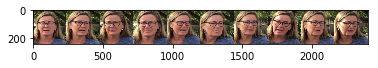

In [17]:
plt.imshow(plt.imread('../test_videos_cut/zmxeiipnqb.jpg', ))
plt.show() 

In [18]:
json_file = [file for file in train_list if  file.endswith('json')][0]
print(f"JSON file: {json_file}")

JSON file: metadata.json


In [19]:
def get_meta_from_json(path):
    df = pd.read_json(os.path.join(DATA_FOLDER, path, json_file))
    df = df.T
    return df

meta_train_df = get_meta_from_json(TRAIN_SAMPLE_FOLDER)

In [20]:
meta = np.array(list(meta_train_df.index))
storage = np.array([file for file in train_list if  file.endswith('mp4')])
print(f"Metadata: {meta.shape[0]}, Folder: {storage.shape[0]}")
print(f"Files in metadata and not in folder: {np.setdiff1d(meta,storage,assume_unique=False).shape[0]}")
print(f"Files in folder and not in metadata: {np.setdiff1d(storage,meta,assume_unique=False).shape[0]}")

Metadata: 400, Folder: 400
Files in metadata and not in folder: 0
Files in folder and not in metadata: 0


In [21]:
train_labels = []
for i in train_imgs:
    name = i.split('/')[2].replace('.jpg','.mp4')
    train_labels.append(meta_train_df[meta_train_df.index==name].iloc[0,0])

In [22]:
train_data = pd.DataFrame()
train_data['class'] = train_labels
train_data['img_name']=train_imgs
train_data

,class,img_name
0,FAKE,../train_videos_cut/esxrvsgpvb.jpg
1,FAKE,../train_videos_cut/djvutyvaio.jpg
2,FAKE,../train_videos_cut/aneclqfpbt.jpg
3,FAKE,../train_videos_cut/asvcrfdpnq.jpg
4,REAL,../train_videos_cut/dzyuwjkjui.jpg
...,...,...
395,FAKE,../train_videos_cut/doanjploai.jpg
396,FAKE,../train_videos_cut/dbhrpizyeq.jpg
397,FAKE,../train_videos_cut/axoygtekut.jpg
398,FAKE,../train_videos_cut/bjkmjilrxp.jpg


In [23]:
new_data = []
new_class = []
for file in tqdm(train_data.loc[train_data['class']=='REAL', 'img_name']):
    im=Image.open(file)
    im=im.convert("RGB")
    r,g,b=im.split()
    r=r.convert("RGB")
    g=g.convert("RGB")
    b=b.convert("RGB")
    im_blur=im.filter(ImageFilter.GaussianBlur)
    im_unsharp=im.filter(ImageFilter.UnsharpMask)
    r.save('..'+file.split('.')[-2]+'_r'+'.jpg')
    new_data.append('..'+file.split('.')[-2]+'_r'+'.jpg')
    new_class.append('REAL')
    g.save('..'+file.split('.')[-2]+'_g'+'.jpg')
    new_data.append('..'+file.split('.')[-2]+'_g'+'.jpg')
    new_class.append('REAL')
    b.save('..'+file.split('.')[-2]+'_b'+'.jpg')
    new_data.append('..'+file.split('.')[-2]+'_b'+'.jpg')
    new_class.append('REAL')
    im_blur.save('..'+file.split('.')[-2]+'_bl'+'.jpg')
    new_data.append('..'+file.split('.')[-2]+'_bl'+'.jpg')
    new_class.append('REAL')
    im_unsharp.save('..'+file.split('.')[-2]+'_un'+'.jpg')
    new_data.append('..'+file.split('.')[-2]+'_un'+'.jpg')
    new_class.append('REAL')
    
new_train_data = pd.DataFrame()
new_train_data['img_name'] = new_data
new_train_data['class'] = new_class
train_data=train_data.append(new_train_data, ignore_index=True)
train_data

/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


,class,img_name
0,FAKE,../train_videos_cut/esxrvsgpvb.jpg
1,FAKE,../train_videos_cut/djvutyvaio.jpg
2,FAKE,../train_videos_cut/aneclqfpbt.jpg
3,FAKE,../train_videos_cut/asvcrfdpnq.jpg
4,REAL,../train_videos_cut/dzyuwjkjui.jpg
...,...,...
780,REAL,../train_videos_cut/asaxgevnnp_r.jpg
781,REAL,../train_videos_cut/asaxgevnnp_g.jpg
782,REAL,../train_videos_cut/asaxgevnnp_b.jpg
783,REAL,../train_videos_cut/asaxgevnnp_bl.jpg


In [24]:
from collections import Counter
Counter(train_data["class"])

Counter({'FAKE': 323, 'REAL': 462})

In [25]:
# creating an empty list
train_image = []

# for loop to read and store frames
for i in tqdm(range(train_data.shape[0])):
    # loading the image and keeping the target size as (224,224,3)
    img = image.load_img(train_data['img_name'][i], target_size=(224,224,3))
    # converting it to array
    img = image.img_to_array(img)
    # normalizing the pixel value
    img = img/255
    # appending the image to the train_image list
    train_image.append(img)
    
# converting the list to numpy array
X = np.array(train_image)

# shape of the array
X.shape

(785, 224, 224, 3)

In [26]:
y = pd.get_dummies(train_data['class'])
base_model = VGG_19(weights='imagenet', include_top=False)
X = base_model.predict(X)
model = Sequential()
model.add(Dense(1024, activation = 'relu',  input_shape = (25088,)))
model.add(Dropout(0.5))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))
from keras.callbacks import ModelCheckpoint
mcp_save = ModelCheckpoint('weight.hdf5', save_best_only=True, monitor='val_loss', mode='min')
model.compile(loss='binary_crossentropy',optimizer='Adam',metrics=['accuracy'])

In [27]:
X = X.reshape(785, 7*7*512)
max = X.max()
X = X/max

In [28]:
model.fit(X, y, epochs=200, callbacks=[mcp_save], batch_size=128)

Epoch 1/200
785/785 [==============================] - 0s 422us/step - loss: 0.7809 - accuracy: 0.5248
Epoch 2/200
785/785 [==============================] - 0s 172us/step - loss: 0.7703 - accuracy: 0.5732
Epoch 3/200
128/785 [===>..........................] - ETA: 0s - loss: 0.8428 - accuracy: 0.3984

/opt/conda/lib/python3.6/site-packages/keras/callbacks/callbacks.py:707: RuntimeWarning: Can save best model only with val_loss available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)


785/785 [==============================] - 0s 192us/step - loss: 0.7745 - accuracy: 0.5019
Epoch 4/200
785/785 [==============================] - 0s 178us/step - loss: 0.7288 - accuracy: 0.5478
Epoch 5/200
785/785 [==============================] - 0s 179us/step - loss: 0.7009 - accuracy: 0.5592
Epoch 6/200
785/785 [==============================] - 0s 169us/step - loss: 0.7057 - accuracy: 0.5554
Epoch 7/200
785/785 [==============================] - 0s 172us/step - loss: 0.6844 - accuracy: 0.5541
Epoch 8/200
785/785 [==============================] - 0s 170us/step - loss: 0.6897 - accuracy: 0.5911
Epoch 9/200
785/785 [==============================] - 0s 171us/step - loss: 0.6717 - accuracy: 0.6038
Epoch 10/200
785/785 [==============================] - 0s 171us/step - loss: 0.6612 - accuracy: 0.5962
Epoch 11/200
785/785 [==============================] - 0s 177us/step - loss: 0.6469 - accuracy: 0.6140
Epoch 12/200
785/785 [==============================] - 0s 171us/step - loss: 0.638

In [29]:
test_image = []

# for loop to read and store frames
for i in tqdm(range(len(test_imgs))):
    # loading the image and keeping the target size as (224,224,3)
    img = image.load_img(test_imgs[i], target_size=(224,224,3))
    # converting it to array
    img = image.img_to_array(img)
    # normalizing the pixel value
    img = img/255
    # appending the image to the train_image list
    test_image.append(img)
    
# converting the list to numpy array
X_test = np.array(test_image)

# shape of the array
X_test.shape

(400, 224, 224, 3)

In [30]:
base_model = VGG_19(weights='imagenet', include_top=False)
X_test = base_model.predict(X_test)

In [31]:
X_test = X_test.reshape(400, 7*7*512)
max = X_test.max()
X_test = X_test/max

In [32]:
result = model.predict(X_test)

In [33]:
filename=[test_imgs[i].split('/')[-1].split('.')[0]+'.mp4' for i in range(len(test_imgs))]


In [34]:
fake_prediction=[result[i][0] for i in range(len(result))]


In [35]:
sample_submission = pd.read_csv("../input/deepfake-detection-challenge/sample_submission.csv")
test_files=glob.glob('./test_videos/*.jpg')
submission=pd.DataFrame()
submission['filename']=filename
submission['label']=fake_prediction


In [36]:
submission.to_csv('submission.csv', index=False)